In [4]:
from moviepy.editor import VideoFileClip
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

[[  1.15396100e+03   0.00000000e+00   6.69706490e+02]
 [  0.00000000e+00   1.14802504e+03   3.85655584e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ -2.41018756e-01  -5.30666106e-02  -1.15811356e-03  -1.28285248e-04
    2.67027151e-02]]


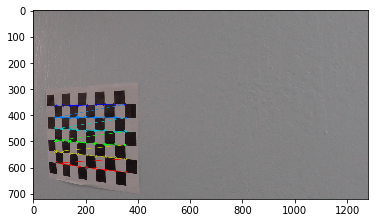

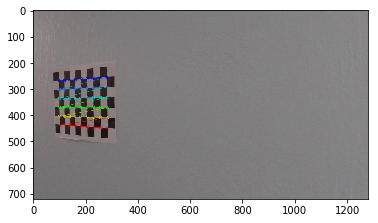

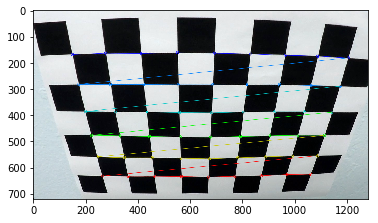

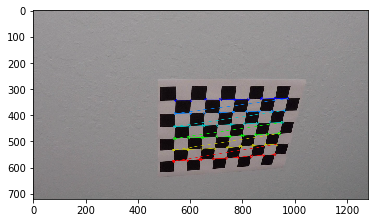

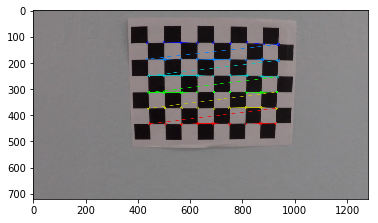

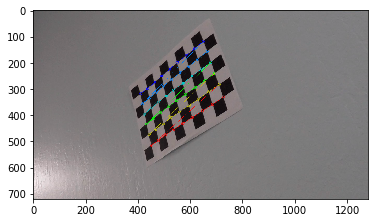

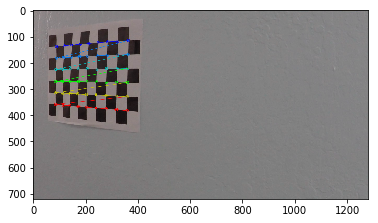

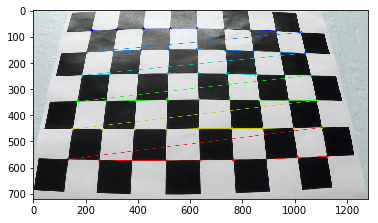

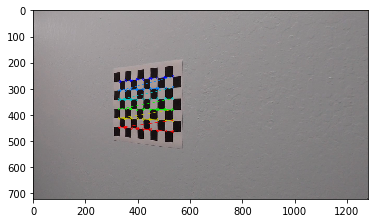

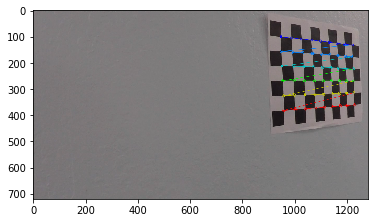

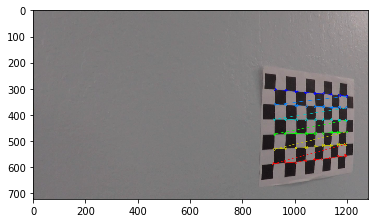

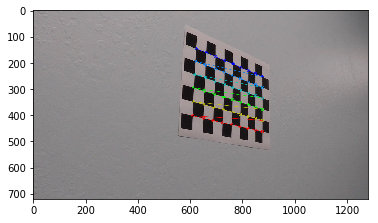

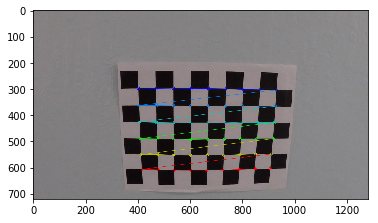

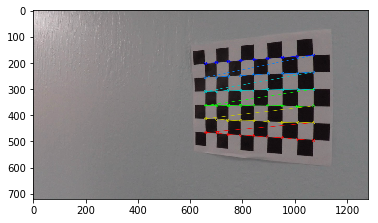

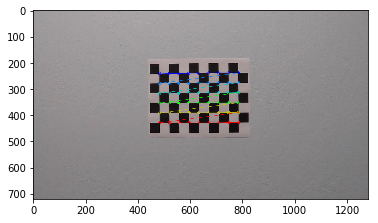

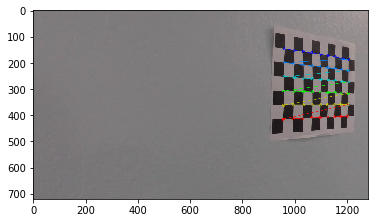

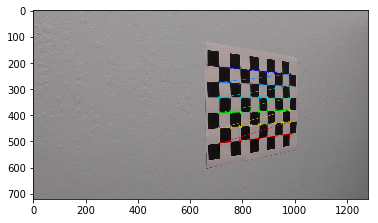

In [10]:
# Calibrating camera

obj_points = []
img_points = []

nx = 9
ny = 6

cal_paths = glob.glob('./camera_cal/*.jpg')

objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for i, path in enumerate(cal_paths):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny))
    if ret == True:
        obj_points.append(objp)
        img_points.append(corners)
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret) 
        plt.figure(i)
        plt.imshow(img)

plt.savefig('./report_images/drawChessboard.png', bbox_inches='tight')
        
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, 
                                                                     gray.shape, None, None) 
print (cameraMatrix)
print (distCoeffs)

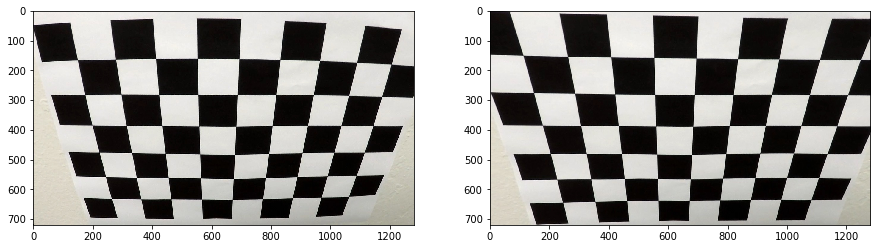

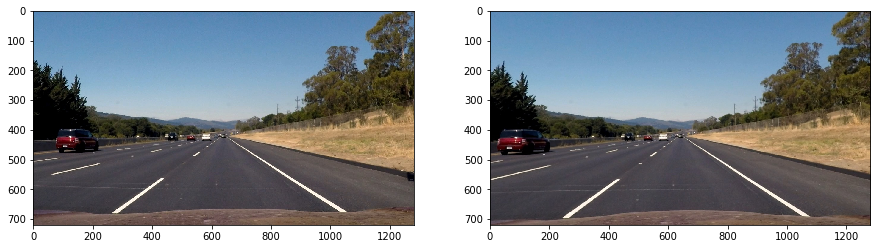

In [11]:
# Test calibration with undistort

img = plt.imread('./camera_cal/calibration2.jpg')
plt.figure(1,figsize=(15,5))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
img_undist = cv2.undistort(img, cameraMatrix, distCoeffs)
plt.imshow(img_undist)
plt.savefig('./report_images/undistorted.png')

img = plt.imread('./test_images/straight_lines2.jpg')
plt.figure(2,figsize=(15,5))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
img_undist = cv2.undistort(img, cameraMatrix, distCoeffs)
plt.imshow(img_undist)
plt.savefig('./report_images/undistorted_straight.png', bbox_inches='tight')

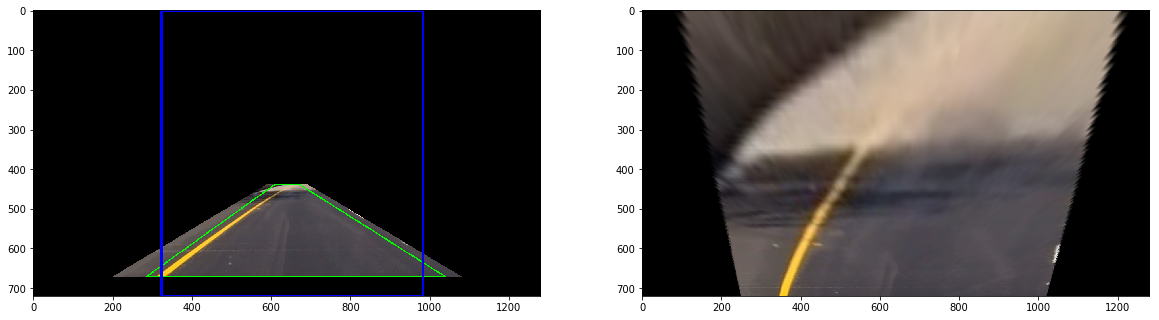

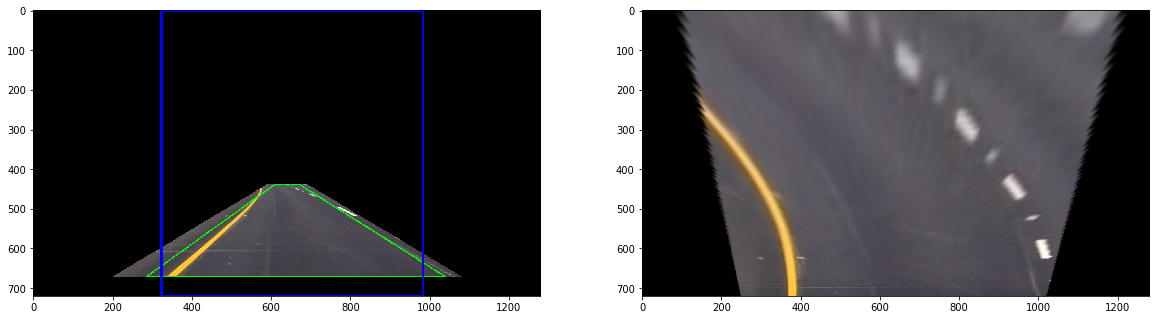

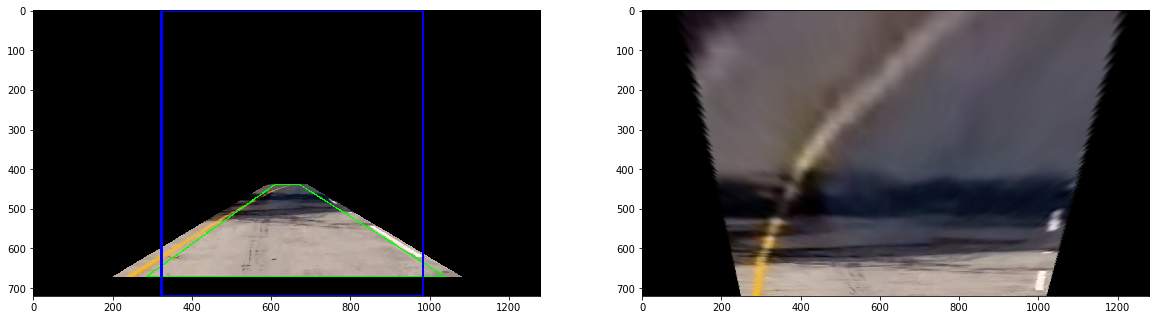

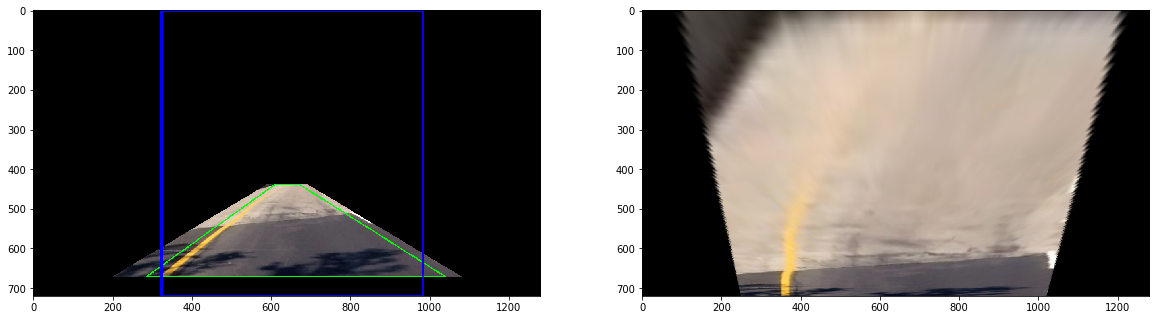

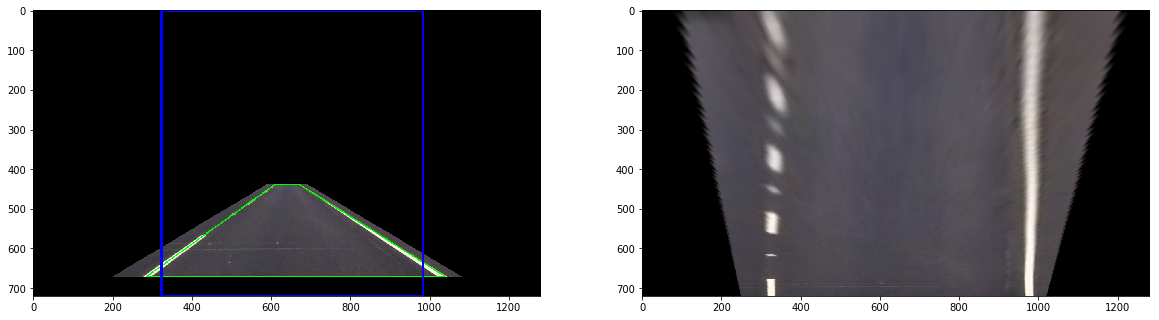

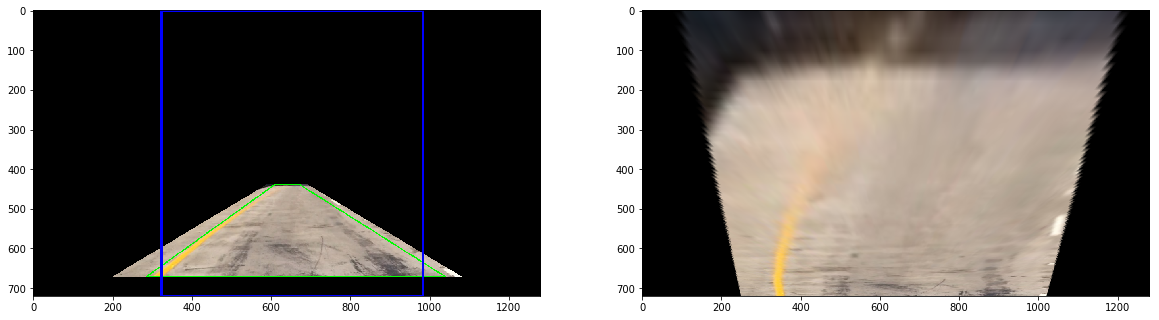

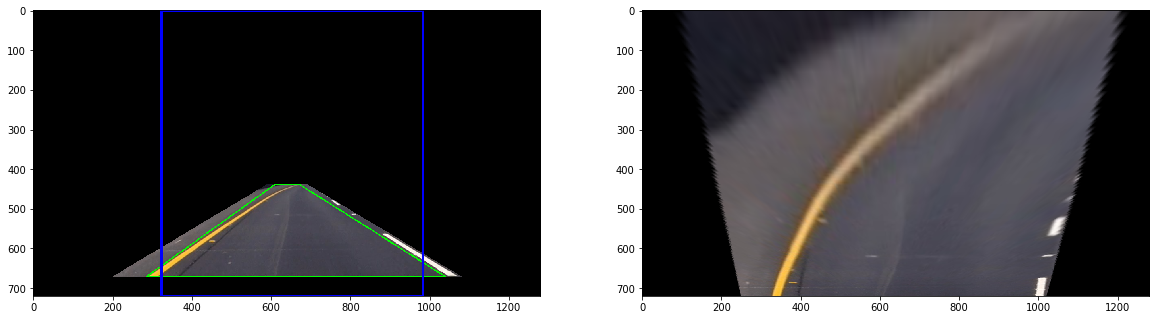

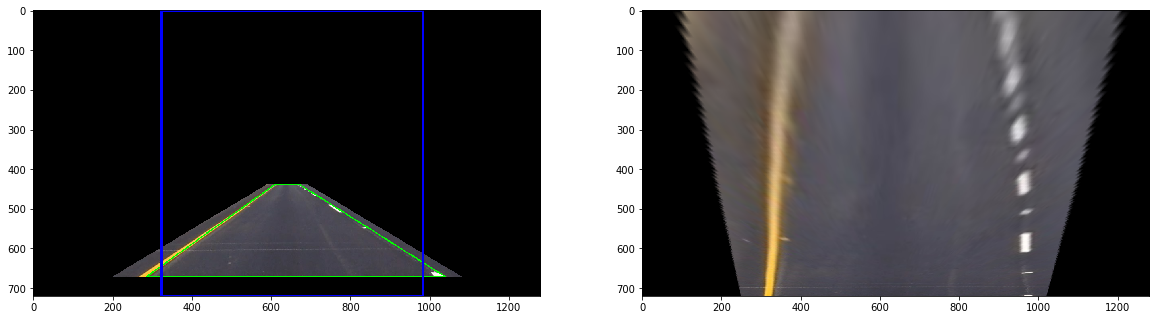

In [5]:
# Test image warping

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

test_paths = glob.glob('./test_images/*.jpg')

for i, path in enumerate(test_paths):
    img = mpimg.imread(path)
    img_undist = cv2.undistort(img, cameraMatrix, distCoeffs)
    plt.figure(i,figsize=(20,10))
    plt.subplot(121)
    plt.imshow(img)
    plt.subplot(122)
    plt.imshow(img_undist)
    vertices = np.array([[(590,438),(img.shape[1]-590,438),(img.shape[1]-200,671),(200,671)]], dtype=np.int32)
    img_undist = region_of_interest(img_undist, vertices)
    
    img_draw = img_undist.copy()
    src = np.int32([[610,438],[670,438],[1039,671],[285,671]])
    dst = np.int32([[274+50,0],[1032-50,0],[1032-50,img.shape[0]],[274+50,img.shape[0]]])
    cv2.polylines(img_draw, [src], True, (0,255,0),2)
    cv2.polylines(img_draw, [dst], True, (0,0,255),5)

    M = cv2.getPerspectiveTransform(np.asarray(src,dtype=np.float32),np.asarray(dst,dtype=np.float32))
    img_warp = cv2.warpPerspective(img_undist, M, (img.shape[1],img.shape[0]))

    plt.figure(i,figsize=(20,10))
    plt.subplot(121)
    plt.imshow(img_draw)
    plt.subplot(122)
    plt.imshow(img_warp)

In [21]:
# TRACKBAR TESTING

from moviepy.editor import VideoFileClip
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def nothing(img):
    pass

cameraMatrix = np.array([[  1.15396100e+03,   0.00000000e+00,   6.69706490e+02],
 [  0.00000000e+00,   1.14802504e+03,   3.85655584e+02],
 [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

distCoeffs = np.array([[ -2.41018756e-01,  -5.30666106e-02,  -1.15811356e-03,  -1.28285248e-04,
    2.67027151e-02]])

#cv2.startWindowThread()
cv2.namedWindow('trackbar')
cv2.namedWindow('original')
cv2.namedWindow('blur')
cv2.namedWindow('edge')
cv2.namedWindow('warp')

test_paths = glob.glob('./test_images/*.jpg')
#img = np.zeros((300,512,3), np.uint8)
cv2.createTrackbar('Blur kernel','trackbar',1,5,nothing)
cv2.createTrackbar('Edge detection method','trackbar',0,2,nothing)
cv2.createTrackbar('Edge filter kernel','trackbar',1,5,nothing)
cv2.createTrackbar('Image number','trackbar',0,len(test_paths)-1,nothing)
cv2.createTrackbar('Color space','trackbar',0,1,nothing)
cv2.createTrackbar('Color channel','trackbar',2,2,nothing)

cv2.createTrackbar('Gradient high threshold','trackbar',255,400,nothing)
cv2.createTrackbar('Gradient low threshold','trackbar',20,400,nothing)



# Set initial parameters
cv2.setTrackbarPos('Edge filter kernel','trackbar',2)
cv2.setTrackbarPos('Color channel','trackbar',2)
cv2.setTrackbarPos('Gradient high threshold','trackbar',255)
cv2.setTrackbarPos('Gradient low threshold','trackbar',20)

HLS = 0
HSV = 1
SOBEL = 0
LAPLACE = 1
CANNY = 2

while(1):
    # get current positions of four trackbars
    kernel_size_blur = 3 + 2*cv2.getTrackbarPos('Blur kernel','trackbar')
    edge_method = cv2.getTrackbarPos('Edge detection method','trackbar')
    kernel_size_edge = 3 + 2*cv2.getTrackbarPos('Edge filter kernel','trackbar')
    img_id = cv2.getTrackbarPos('Image number','trackbar')
    color_space = cv2.getTrackbarPos('Color space','trackbar')
    channel = cv2.getTrackbarPos('Color channel','trackbar')
    high_thresh = cv2.getTrackbarPos('Gradient high threshold','trackbar')
    low_thresh = cv2.getTrackbarPos('Gradient low threshold','trackbar')

    img_origin = cv2.imread(test_paths[img_id])
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break

    img_undist = cv2.undistort(img_origin, cameraMatrix, distCoeffs)
    #img_undist = img_undist[400:img_undist.shape[0],:,:] # Cropping

    img_blur = cv2.GaussianBlur(img_undist, (kernel_size_blur,kernel_size_blur), 0)

    # Color space conversion
    if (color_space == HLS):
        img_cvtColor = cv2.cvtColor(img_blur,cv2.COLOR_BGR2HLS)
    elif (color_space == HSV):
        img_cvtColor = cv2.cvtColor(img_blur,cv2.COLOR_BGR2HSV)
    
    img_channel = img_cvtColor[:,:,channel]
    img_bin = np.zeros_like(img_channel)

    if (edge_method == SOBEL):
        sobel_x = cv2.Sobel(img_channel,cv2.CV_64F,1,0,ksize=kernel_size_edge)
        sobel_y = cv2.Sobel(img_channel,cv2.CV_64F,0,1,ksize=kernel_size_edge)
        angle = np.arctan2(sobel_y,sobel_x)
        sobel_x = np.absolute(sobel_x)
        sobel_y = np.absolute(sobel_y)
        img_edge = np.sqrt(np.power(sobel_x,2)+np.power(sobel_y,2))
        #img_bin = np.zeros_like(img_edge)
        #img_bin[(img_edge > low_thresh) & (img_edge < high_thresh)] = 255
    elif (edge_method == LAPLACE):
        img_edge = cv2.Laplacian(img_channel,cv2.CV_64F,ksize=kernel_size_edge)
        #img_bin = img_edge
        print ('min value of laplace',np.min(img_edge))
    elif (edge_method == CANNY):
        print(kernel_size_edge)
        img_edge = cv2.Canny(img_channel,low_thresh, high_thresh, apertureSize=kernel_size_edge)
        img_bin = img_edge

    if ((edge_method == SOBEL) | (edge_method == LAPLACE)):
        img_edge = np.asarray(255*img_edge/np.max(img_edge),dtype=np.uint8)
        img_bin[(img_edge > low_thresh) & (img_edge < high_thresh)] = 255
    

    src = np.int32([[580,458],[700,458],[1039,671],[285,671]])
    dst = np.int32([[274+100,0],[1032-100,0],[1032-100,img_origin.shape[0]],[274+100,img_origin.shape[0]]])
    M = cv2.getPerspectiveTransform(np.asarray(src,dtype=np.float32),np.asarray(dst,dtype=np.float32))
    img_warp = cv2.warpPerspective(img_bin, M, (img_origin.shape[1],img_origin.shape[0]))
    

    # Resize images
    img_undist = cv2.resize(img_undist,(0,0), fx=0.5,fy=0.5) 
    img_blur = cv2.resize(img_blur,(0,0), fx=0.5,fy=0.5)
    img_bin = cv2.resize(img_bin,(0,0), fx=0.5,fy=0.5)
    img_warp = cv2.resize(img_warp,(0,0), fx=0.5,fy=0.5)

    
    cv2.imshow('original', img_undist)
    cv2.imshow('blur', img_blur)
    cv2.imshow('edge', img_bin)
    cv2.imshow('warp', img_warp)

cv2.destroyAllWindows()

KeyboardInterrupt: 

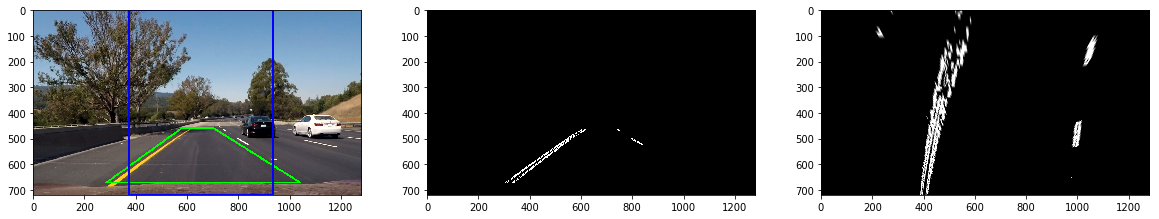

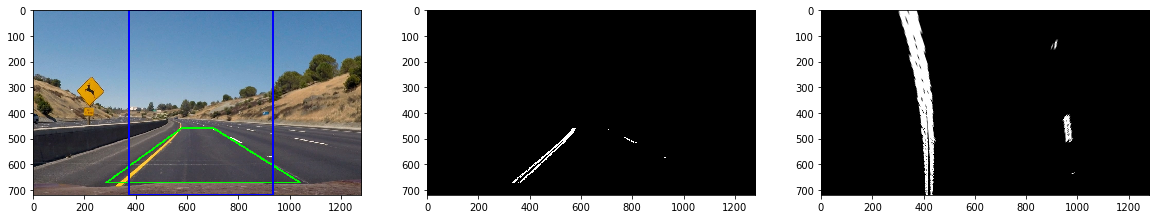

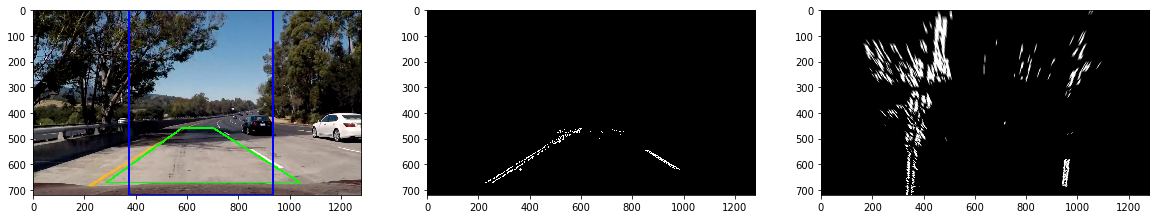

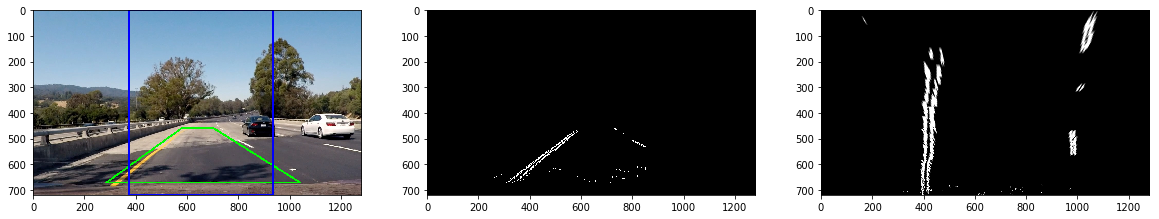

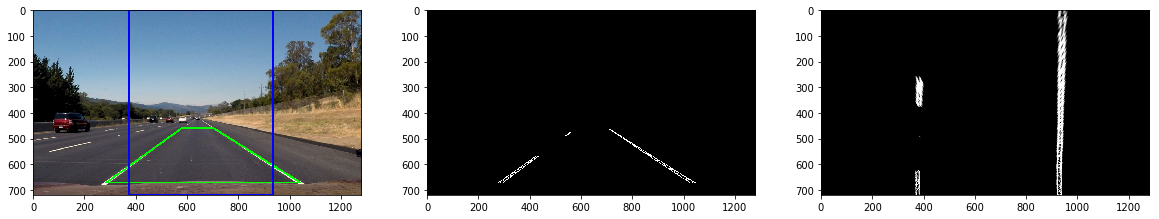

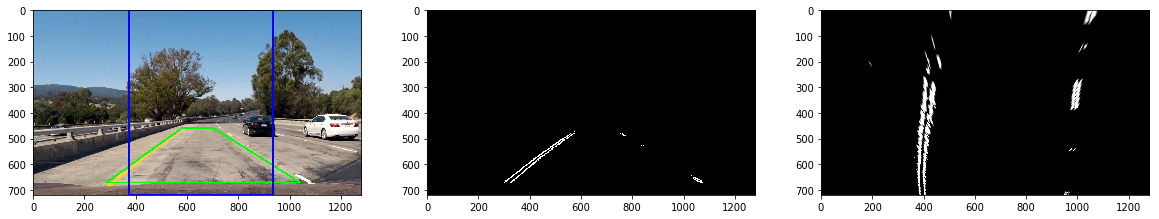

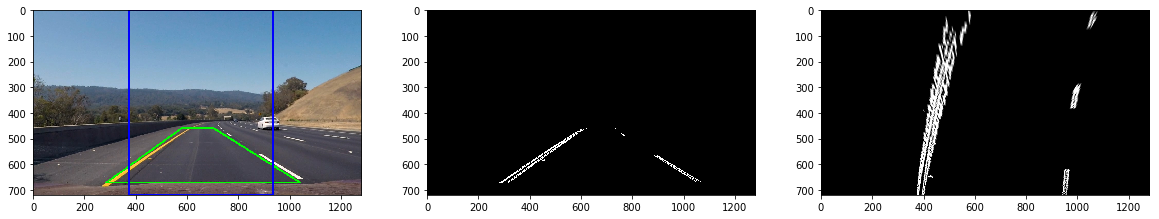

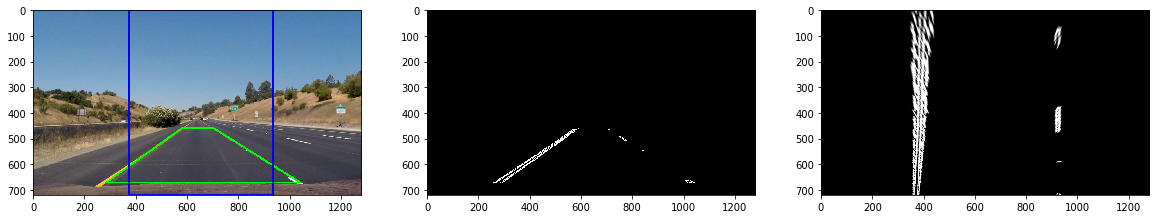

In [9]:
# SINGLE IMAGE PIPELINE

test_paths = glob.glob('./test_images/*.jpg')

kernel_size=3
low_thresh = 20
high_thresh = 255

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

for i, path in enumerate(test_paths):
    img = mpimg.imread(path)
    
    img_undist = cv2.undistort(img, cameraMatrix, distCoeffs)
    #img_undist = img_undist[400:img_undist.shape[0],:,:]
    img_hls = cv2.cvtColor(img_undist,cv2.COLOR_RGB2HLS)
    img_sat = img_hls[:,:,2]
    sobel_x = cv2.Sobel(img_sat,cv2.CV_64F,1,0,ksize=kernel_size)
    sobel_y = cv2.Sobel(img_sat,cv2.CV_64F,0,1,ksize=kernel_size)
    #angle = np.arctan2(sobel_y,sobel_x)
    sobel_x = np.absolute(sobel_x)

    grad = sobel_x
    img_bin = np.asarray(255*grad/np.max(grad),dtype=np.uint8)
    
    vertices = np.array([[(530,458),(img.shape[1]-530,458),(img.shape[1]-200,671),(200,671)]], dtype=np.int32)
    img_bin = region_of_interest(img_bin, vertices)
    
    img_out = np.zeros_like(img_bin)
    img_out[(img_bin > low_thresh) & (img_bin < high_thresh)] = 255

    img_draw = img.copy()
    src = np.int32([[580,458],[700,458],[1039,671],[285,671]])
    dst = np.int32([[274+100,0],[1032-100,0],[1032-100,img.shape[0]],[274+100,img.shape[0]]])
    cv2.polylines(img_draw, [src], True, (0,255,0),5)
    cv2.polylines(img_draw, [dst], True, (0,0,255),5)
    M = cv2.getPerspectiveTransform(np.asarray(src,dtype=np.float32),np.asarray(dst,dtype=np.float32))
    img_warp = cv2.warpPerspective(img_out, M, (img.shape[1],img.shape[0]))

    plt.figure(i,figsize=(20,10))
    plt.subplot(131)
    plt.imshow(img_draw)
    plt.subplot(133)
    plt.imshow(img_warp, cmap='gray')
    plt.subplot(132)
    plt.imshow(img_out, cmap='gray')
    
plt.savefig('./report_images/binary_and_perspective.png', bbox_inches='tight')

0.945165245088
1.20379361588
-0.828377712371


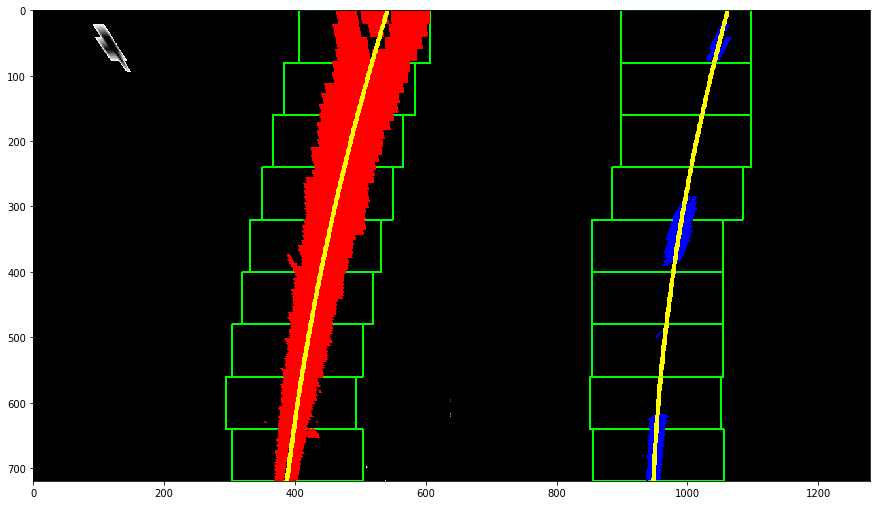

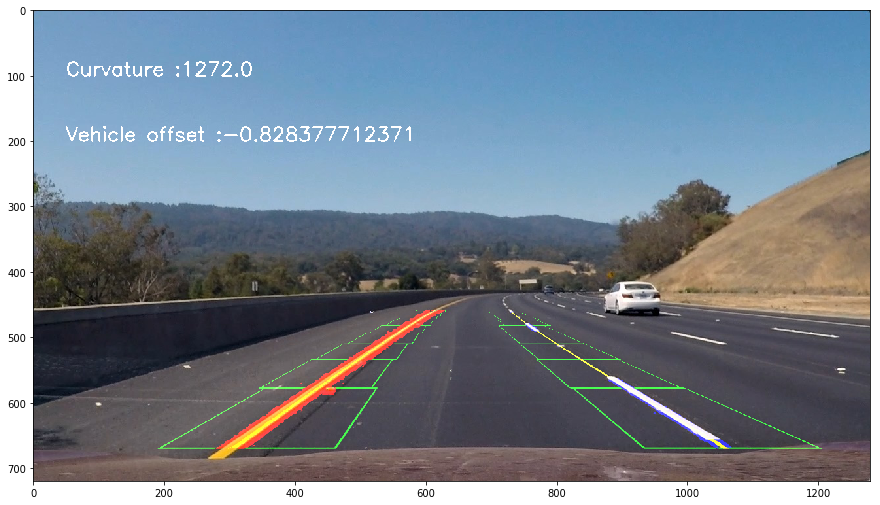

In [25]:
# SLIDING WINDOW AND POLYNOMIAL FITTING

from moviepy.editor import VideoFileClip
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

cameraMatrix = np.array([[  1.15396100e+03,   0.00000000e+00,   6.69706490e+02],
 [  0.00000000e+00,   1.14802504e+03,   3.85655584e+02],
 [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

distCoeffs = np.array([[ -2.41018756e-01,  -5.30666106e-02,  -1.15811356e-03,  -1.28285248e-04,
    2.67027151e-02]])

img_origin = cv2.imread('./test_images/test3.jpg')

img_undist = cv2.undistort(img_origin, cameraMatrix, distCoeffs)

img_blur = cv2.GaussianBlur(img_undist, (3,3), 0)

img_cvtColor = cv2.cvtColor(img_blur,cv2.COLOR_BGR2HLS)
img_channel = img_cvtColor[:,:,2]
img_bin = np.zeros_like(img_channel)

sobel_x = cv2.Sobel(img_channel,cv2.CV_64F,1,0,ksize=5)
#sobel_y = cv2.Sobel(img_channel,cv2.CV_64F,0,1,ksize=kernel_size_edge)

sobel_x = np.absolute(sobel_x)
#sobel_y = np.absolute(sobel_y)
#img_edge = np.sqrt(np.power(sobel_x,2)+np.power(sobel_y,2))
img_edge = sobel_x
img_edge = np.asarray(255*img_edge/np.max(img_edge),dtype=np.uint8)
img_bin[(img_edge > 8) & (img_edge <= 255)] = 255

vertices = np.array([[(520,458),(img_origin.shape[1]-520,458),(img_origin.shape[1]-200,671),(200,671)]], dtype=np.int32)
img_bin = region_of_interest(img_bin, vertices)

src = np.int32([[580,458],[700,458],[1039,671],[285,671]])
dst = np.int32([[274+100,0],[1032-100,0],[1032-100,img_origin.shape[0]],[274+100,img_origin.shape[0]]])
M = cv2.getPerspectiveTransform(np.asarray(src,dtype=np.float32),np.asarray(dst,dtype=np.float32))
img_warp = cv2.warpPerspective(img_bin, M, (img_origin.shape[1],img_origin.shape[0]))


#plt.figure(figsize=(8,8))
#plt.imshow(cv2.cvtColor(region_of_interest(img_origin, vertices),cv2.COLOR_BGR2RGB))

#plt.figure(figsize=(8,8))
#plt.imshow(img_bin,cmap='gray')

#plt.figure(figsize=(8,8))
#plt.imshow(img_warp,cmap='gray')

# Resize images
#img_undist = cv2.resize(img_undist,(0,0), fx=0.5,fy=0.5) 
#img_blur = cv2.resize(img_blur,(0,0), fx=0.5,fy=0.5)
#img_bin = cv2.resize(img_bin,(0,0), fx=0.5,fy=0.5)
#img_warp = cv2.resize(img_warp,(0,0), fx=0.5,fy=0.5)

#plt.figure(figsize=(8,8))
#histogram = np.sum(img_warp[img_warp.shape[0]/2:,:], axis=0)
#plt.plot(histogram)

binary_warped = img_warp

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
img_poly = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(img_poly,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(img_poly,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)



# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

poly_draw_left = np.dstack((left_fitx,ploty))
poly_draw_left = np.asarray(poly_draw_left, dtype=np.int32)
poly_draw_right = np.dstack((right_fitx,ploty))
poly_draw_right = np.asarray(poly_draw_right, dtype=np.int32)

img_poly[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
img_poly[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

cv2.polylines(img_poly, poly_draw_left, False, (255,255,0),thickness=5)
cv2.polylines(img_poly, poly_draw_right, False, (255,255,0),thickness=5)

plt.figure(figsize=(15,15))
plt.imshow(img_poly)
plt.savefig('./report_images/fit.png', bbox_inches='tight')

plt.figure(figsize=(15,15))

M = cv2.getPerspectiveTransform(np.asarray(dst,dtype=np.float32),np.asarray(src,dtype=np.float32))
img_warp = cv2.warpPerspective(img_poly, M, (img_origin.shape[1],img_origin.shape[0]))


img_origin = cv2.cvtColor(img_origin,cv2.COLOR_RGB2BGR)
img_out = cv2.bitwise_or(img_origin,img_warp)

y_eval = 550
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
cv2.putText(img_out, 'Curvature :' + str(round(left_curverad)), (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)

# Calculate offset from center
left_position = (left_fit_cr[0]*binary_warped.shape[0]**2 + left_fit_cr[1]*binary_warped.shape[0] + left_fit_cr[2])*xm_per_pix
right_position = (right_fit_cr[0]*binary_warped.shape[0]**2 + right_fit_cr[1]*binary_warped.shape[0] + right_fit_cr[2])*xm_per_pix
vehicle_position = binary_warped.shape[0]/2*xm_per_pix
print (left_position)
print (right_position)
vehicle_offset = (right_position+left_position)/2-vehicle_position
print (vehicle_offset)
cv2.putText(img_out, 'Vehicle offset :' + str(vehicle_offset), (50,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)

plt.imshow(img_out)
plt.savefig('./report_images/unwarp.png', bbox_inches='tight')

#### To-do
- threshold fo color channels

In [27]:
# FINAL CODE FOR VIDEO

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

lane_found = False
left_fit = []
right_fit = []

def find_lane(img_origin):
    
    global lane_found, left_fit, right_fit
    
    if (len(left_fit) != 0):
        fit_difference = np.sum(np.absolute(left_fit-right_fit))
        if (fit_difference < 0.1):
            lane_found = False
    
    cameraMatrix = np.array([[  1.15396100e+03,   0.00000000e+00,   6.69706490e+02],
         [  0.00000000e+00,   1.14802504e+03,   3.85655584e+02],
         [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])

    distCoeffs = np.array([[ -2.41018756e-01,  -5.30666106e-02,  -1.15811356e-03,  -1.28285248e-04,
            2.67027151e-02]])
    
    img_undist = cv2.undistort(img_origin, cameraMatrix, distCoeffs)

    img_blur = cv2.GaussianBlur(img_undist, (3,3), 0)

    img_cvtColor = cv2.cvtColor(img_blur,cv2.COLOR_BGR2HLS)
    img_channel = img_cvtColor[:,:,2]
    img_bin = np.zeros_like(img_channel)

    sobel_x = cv2.Sobel(img_channel,cv2.CV_64F,1,0,ksize=5)
    #sobel_y = cv2.Sobel(img_channel,cv2.CV_64F,0,1,ksize=kernel_size_edge)

    sobel_x = np.absolute(sobel_x)
    #sobel_y = np.absolute(sobel_y)
    #img_edge = np.sqrt(np.power(sobel_x,2)+np.power(sobel_y,2))
    img_edge = sobel_x
    img_edge = np.asarray(255*img_edge/np.max(img_edge),dtype=np.uint8)
    img_bin[(img_edge > 8) & (img_edge <= 255)] = 255
    
    #vertices = np.array([[(590,438),(img.shape[1]-590,438),(img.shape[1]-200,671),(200,671)]], dtype=np.int32)
    #img_undist = region_of_interest(img_undist, vertices)
    
    #img_draw = img_undist.copy()
    #src = np.int32([[610,438],[670,438],[1039,671],[285,671]])
    #dst = np.int32([[274+50,0],[1032-50,0],[1032-50,img.shape[1]],[274+50,img.shape[1]]])
    
    
    vertices = np.array([[(530,458),(img_origin.shape[1]-530,458),(img_origin.shape[1]-200,671),(200,671)]], dtype=np.int32)
    #vertices = np.array([[(590,438),(img_origin.shape[1]-590,438),(img_origin.shape[1]-200,671),(200,671)]], dtype=np.int32)
    img_bin = region_of_interest(img_bin, vertices)

    src = np.int32([[580,458],[700,458],[1039,671],[285,671]])
    dst = np.int32([[274+100,0],[1032-100,0],[1032-100,img_origin.shape[0]],[274+100,img_origin.shape[0]]])
    #src = np.int32([[610,438],[670,438],[1039,671],[285,671]])
    #dst = np.int32([[274+50,0],[1032-50,0],[1032-50,img_origin.shape[0]],[274+50,img_origin.shape[0]]])
    M = cv2.getPerspectiveTransform(np.asarray(src,dtype=np.float32),np.asarray(dst,dtype=np.float32))
    binary_warped = cv2.warpPerspective(img_bin, M, (img_origin.shape[1],img_origin.shape[0]))

    
    img_poly = np.dstack((binary_warped, binary_warped, binary_warped))*255
    if (lane_found == False):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        img_poly = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(img_poly,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(img_poly,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        lane_found = True
        
    elif (lane_found == True):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]   

    if ((len(lefty) >= 3) & (len(righty) >=3) ):
        lane_found = True
    else:
        lane_found = False
        
    if (lane_found == True):
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)


        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        poly_draw_left = np.dstack((left_fitx,ploty))
        poly_draw_left = np.asarray(poly_draw_left, dtype=np.int32)
        poly_draw_right = np.dstack((right_fitx,ploty))
        poly_draw_right = np.asarray(poly_draw_right, dtype=np.int32)

        img_poly[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        img_poly[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 0]

        cv2.polylines(img_poly, poly_draw_left, False, (255,255,0),thickness=5)
        cv2.polylines(img_poly, poly_draw_right, False, (255,255,0),thickness=5)

        M = cv2.getPerspectiveTransform(np.asarray(dst,dtype=np.float32),np.asarray(src,dtype=np.float32))
        img_warp = cv2.warpPerspective(img_poly, M, (img_origin.shape[1],img_origin.shape[0]))
        
        #img_origin = cv2.cvtColor(img_origin,cv2.COLOR_RGB2BGR)
        img_out = cv2.bitwise_or(img_origin,img_warp)
        
        y_eval = 550
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        cv2.putText(img_out, 'Curvature :' + str(round(left_curverad)), (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255))
        
        # Calculate offset from center
        left_position = (left_fit_cr[0]*binary_warped.shape[0]**2 + left_fit_cr[1]*binary_warped.shape[0] + left_fit_cr[2])*xm_per_pix
        right_position = (right_fit_cr[0]*binary_warped.shape[0]**2 + right_fit_cr[1]*binary_warped.shape[0] + right_fit_cr[2])*xm_per_pix
        vehicle_position = binary_warped.shape[0]/2*xm_per_pix
        vehicle_offset = (right_position+left_position)/2-vehicle_position
        cv2.putText(img_out, 'Vehicle offset :' + str(vehicle_offset), (50,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)

        
        return img_out
    
    elif (lane_found == False):
        return img_origin


In [ ]:
input_video = 'project_video.mp4'
output_video = 'lane_detection.mp4'
input_clip = VideoFileClip(input_video,audio=False)
output_clip = input_clip.fl_image(find_lane)
output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video lane_detection.mp4
[MoviePy] Writing video lane_detection.mp4



 93%|█████████▎| 1172/1261 [03:48<00:17,  5.22it/s]